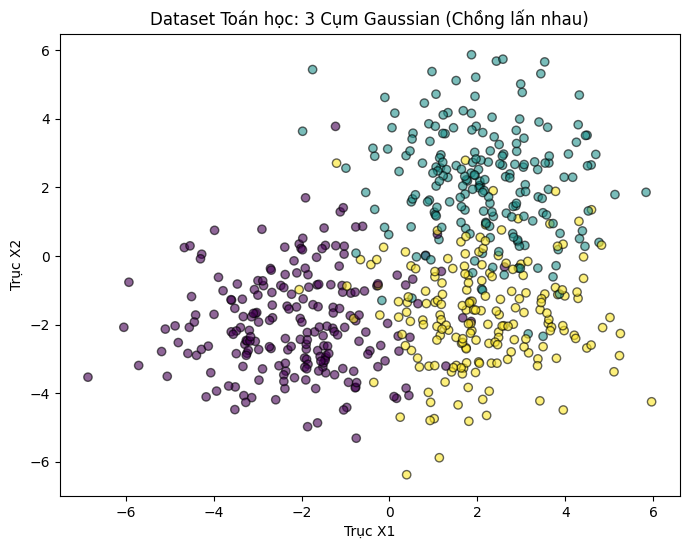

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs


n_samples = 1000
centers = [(-2, -2), (2, 2), (2, -2)]
cluster_std = 1.5
random_state = 42

X_np, y_np = make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std, random_state=random_state)


X = torch.from_numpy(X_np).float()
y = torch.from_numpy(y_np).long()


X_train, y_train = X[:600], y[:600]
X_cal, y_cal = X[600:800], y[600:800]
X_test, y_test = X[800:], y[800:]

# Vẽ dữ liệu thô để hình dung
plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', alpha=0.6, edgecolors='k')
plt.title("Dataset Toán học: 3 Cụm Gaussian (Chồng lấn nhau)")
plt.xlabel("Trục X1")
plt.ylabel("Trục X2")
plt.show()

In [ ]:
model = nn.Sequential(
    nn.Linear(2, 16),
    nn.ReLU(),
    nn.Linear(16, 3)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
print("Đang train model...")
for epoch in range(200):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

print("Loss:", loss.item())

Đang train model...
Train xong! Loss cuối cùng: 0.297035813331604


In [ ]:
def get_scores(model, X_input, y_target):
    """Tính Non-conformity Score: s = 1 - p_true (Mục 4.2)"""
    model.eval()
    with torch.no_grad():
        logits = model(X_input)
        probs = torch.softmax(logits, dim=1)
        true_probs = probs[range(len(y_target)), y_target]
        scores = 1.0 - true_probs
    return scores.numpy()

def get_quantile(scores, alpha):
    """Tính ngưỡng q_level (Mục 5.2)"""
    n = len(scores)
    q_val = np.ceil((n + 1) * (1 - alpha)) / n
    q_val = min(1.0, q_val)
    q_hat = np.quantile(scores, q_val, method='higher')
    return q_hat
alpha = 0.1
cal_scores = get_scores(model, X_cal, y_cal)

q_hat = get_quantile(cal_scores, alpha)

print(f"Ngưỡng q_hat tìm được: {q_hat:.4f}")
print(f"Nghĩa là: Nếu xác suất dự đoán < {1-q_hat:.4f} thì coi là không chắc chắn.")

Ngưỡng q_hat tìm được: 0.7539
Nghĩa là: Nếu xác suất dự đoán < 0.2461 thì coi là không chắc chắn.


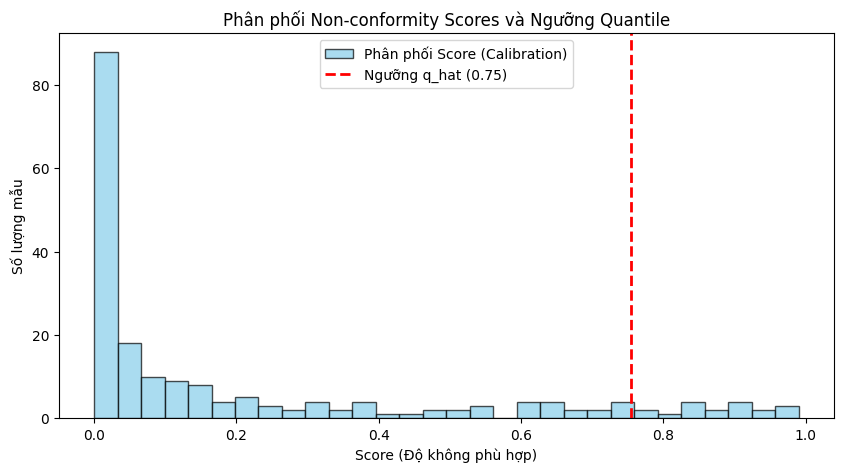

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(cal_scores, bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Phân phối Score (Calibration)')
plt.axvline(q_hat, color='red', linestyle='dashed', linewidth=2, label=f'Ngưỡng q_hat ({q_hat:.2f})')
plt.title("Phân phối Non-conformity Scores và Ngưỡng Quantile")
plt.xlabel("Score (Độ không phù hợp)")
plt.ylabel("Số lượng mẫu")
plt.legend()
plt.show()

/tmp/ipython-input-1638399602.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
/tmp/ipython-input-1638399602.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.arange(y_min, y_max, 0.1))


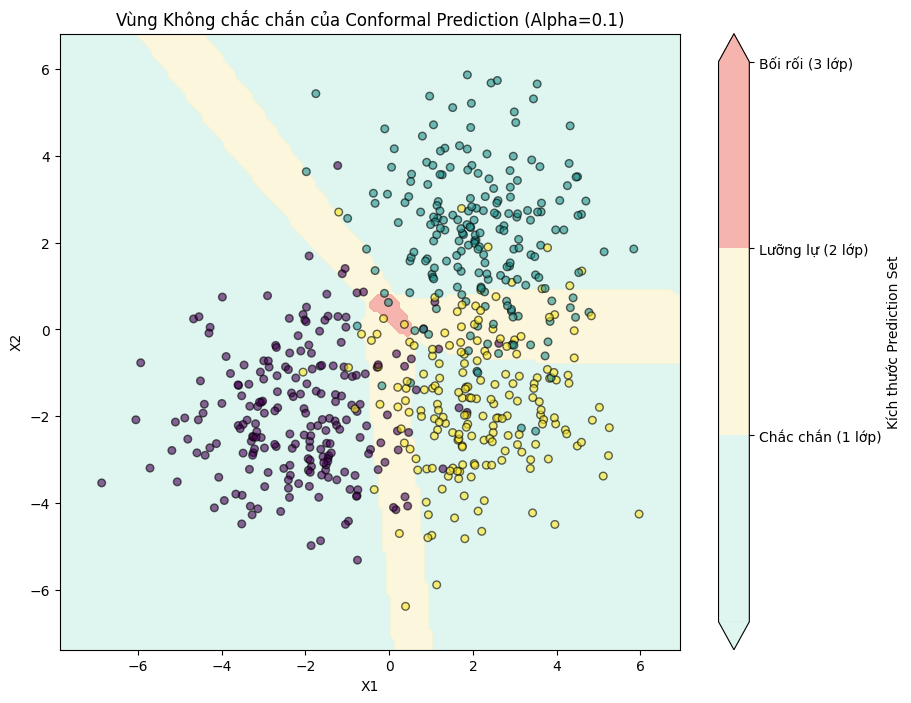

In [ ]:
def plot_conformal_boundary(model, X_train, y_train, q_hat):
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    grid_tensor = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()

    model.eval()
    with torch.no_grad():
        logits = model(grid_tensor)
        probs = torch.softmax(logits, dim=1).numpy()

    threshold = 1 - q_hat
    set_sizes = (probs >= threshold).sum(axis=1)
    set_sizes = set_sizes.reshape(xx.shape)

    plt.figure(figsize=(10, 8))

    contour = plt.contourf(xx, yy, set_sizes, levels=[0, 1, 2, 3],
                           colors=['#d1f2eb', '#fcf3cf', '#f1948a'],
                           extend='both', alpha=0.7)

    # Vẽ lại các điểm dữ liệu train
    scatter = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train,
                          edgecolors='k', cmap='viridis', s=30, alpha=0.6)

    # Chú thích
    cbar = plt.colorbar(contour, ticks=[1, 2, 3])
    cbar.ax.set_yticklabels(['Chắc chắn (1 lớp)', 'Lưỡng lự (2 lớp)', 'Bối rối (3 lớp)'])
    cbar.set_label('Kích thước Prediction Set')

    plt.title(f"Vùng Không chắc chắn của Conformal Prediction (Alpha={alpha})")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.show()

# Gọi hàm vẽ
plot_conformal_boundary(model, X_train, y_train, q_hat)